# Tarea 1: MyAnimeRecSys

## Integrantes:


- Benjamín Farías V.
- Benjamín Lepe M.

# Setup

Primero importamos las librerías necesarias:

In [12]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import json
from IPython.display import display
from time import time
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA


%matplotlib inline
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(14, 10)})

Luego se lee el dataset de training y se carga en un DataFrame, binarizando el rating para ignorar aquellos animes que recibieron un rating bajo:

In [2]:
df_train = pd.read_csv('datasets/train.csv', sep=',')
df_train.rating = [1 if x >= 7 else 0 for x in df_train.rating]  # Consider relevant if rating >= 7
df_train.head()

,user_id,anime_id,rating
0,290025,36793,1
1,166392,30123,1
2,57349,16774,1
3,147605,22763,1
4,16310,15699,0


Lo mismo para el dataset de validation:

In [3]:
df_val = pd.read_csv('datasets/val.csv', sep=',')
df_val.rating = [1 if x >= 7 else 0 for x in df_val.rating]  # Consider relevant if rating >= 7
df_val.head()

,user_id,anime_id,rating
0,50106,28883,1
1,100033,8514,0
2,301396,1726,0
3,324857,853,1
4,144230,31442,0


Y para el dataset de testing:

In [4]:
df_test = pd.read_csv('datasets/test_users.csv', sep=',')
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test.head()

,user_id
0,125862
1,246612
2,925
3,136160
4,174689


Además, cargamos un dataset que contiene información adicional sobre cada anime:

In [5]:
df_info = pd.read_pickle('datasets/anime_info.pkl')

Para evaluar el rendimiento en ciertos métodos de recomendación, se definen funciones auxiliares que calculan las métricas MAP y nDCG:

In [6]:
# Eval metrics
# From: https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

# Actividad 1

Para encontrar la distribución del número de interacciones por usuario, obtenemos la cantidad de interacciones por usuario y luego agrupamos a los usuarios que tienen una actividad similar, representado como un histograma:

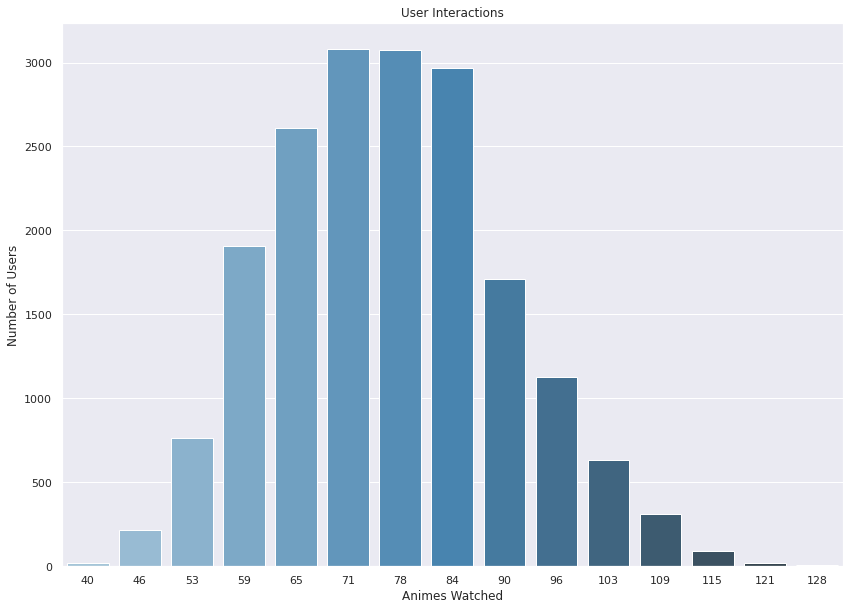

In [7]:
users = df_train['user_id']
user_counts = users.value_counts().to_list()
user_interactions, user_bins = np.histogram(user_counts, bins=15)
user_bins = user_bins.round().astype(int)[:-1]
ax = sns.barplot(x=user_bins, y=user_interactions, palette='Blues_d')
ax.set(title='User Interactions', xlabel='Animes Watched', ylabel='Number of Users')
plt.show()

Se obtienen los 5 usuarios más activos según su cantidad de interacciones:

In [8]:
top_users = users.value_counts()[:5]
print('Usuarios más activos:')
print('user_id  n_interactions')
print(top_users)
print(f'\nPorcentaje atribuido a los 5 usuarios más activos: {100 * top_users.sum() / users.count()} %')

Usuarios más activos:
user_id  n_interactions
297988    134
469       131
214484    129
6088      129
131228    128
Name: user_id, dtype: int64

Porcentaje atribuido a los 5 usuarios más activos: 0.04413394754771856 %


Para la distribución de interacciones por anime, se obtiene la cantidad de usuarios que han visto cada uno, y luego se agrupan según cantidad de usuarios similar. El resultado es el siguiente histograma:

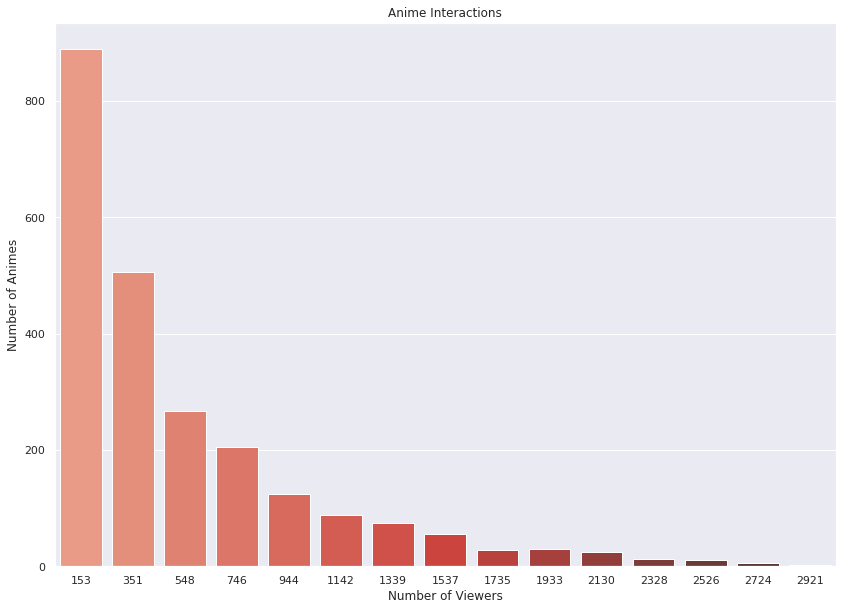

In [9]:
animes = df_train['anime_id']
anime_counts = animes.value_counts().to_list()
anime_interactions, anime_bins = np.histogram(anime_counts, bins=15)
anime_bins = anime_bins.round().astype(int)[:-1]
ax = sns.barplot(x=anime_bins, y=anime_interactions, label='Total', palette='Reds_d')
ax.set(title='Anime Interactions', xlabel='Number of Viewers', ylabel='Number of Animes')
plt.show()

Se obtienen los 5 animes más populares, junto a sus nombres:

In [10]:
top_animes = animes.value_counts()[:5]
top_ids = top_animes.keys().to_list()
top_anime_info = df_info[df_info['anime_id'].isin(top_ids)][['anime_id', 'Name']]
print('Animes más vistos:')
display(top_anime_info.style.hide_index())
print(f'\nPorcentaje atribuido a los 5 animes más vistos: {100 * top_animes.sum() / animes.count()} %')

Animes más vistos:


anime_id,Name
1535,Death Note
6547,Angel Beats!
11757,Sword Art Online
16498,Shingeki no Kyojin
19815,No Game No Life



Porcentaje atribuido a los 5 animes más vistos: 1.0080302090430526 %


Para terminar con la exploración de los datos, se genera una tabla resumen con la cantidad de usuarios y animes, promedios y desviación estándar de animes/usuarios por usuario/anime, así como la densidad del dataset:

In [11]:
n_users = len(users.value_counts())
n_animes = len(animes.value_counts())
avg_users = users.value_counts().mean()
std_users = users.value_counts().std()
avg_animes = animes.value_counts().mean()
std_animes = animes.value_counts().std()
density = len(df_train) / (n_users * n_animes)
sparsity = 1 - density

In [12]:
stats = pd.DataFrame([(n_users, n_animes, avg_users, std_users, avg_animes, std_animes, density * 100, sparsity * 100)],
    columns=['n_users', 'n_items', 'avg_animes_by_user', 'std_animes_by_user',
            'avg_users_by_anime', 'std_users_by_anime', 'density (%)', 'sparsity (%)'])
stats.style.hide_index()

n_users,n_items,avg_animes_by_user,std_animes_by_user,avg_users_by_anime,std_users_by_anime,density (%),sparsity (%)
18552,2326,79.509217,13.701655,634.159501,513.600988,3.418281,96.581719


# Actividad 2

Se comienza entrenando el modelo Most Popular sobre el dataset de training:

In [13]:
most_popular = pyreclab.MostPopular(dataset='datasets/train.csv',
                                    dlmchar=b',',
                                    header=True,
                                    usercol=0,
                                    itemcol=1,
                                    ratingcol=2)
most_popular.train()

Ahora se evalúa sobre el de validación, entregando 30 recomendaciones para cada usuario:

In [14]:
top_n = 30

recommendList, maprec, ndcg = most_popular.testrec(input_file='datasets/val.csv',
                                            dlmchar=b',',
                                            header=True,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=7,
                                            includeRated=False)

print('Most Popular')
print(f'MAP@{top_n}: {maprec}\nNDCG@{top_n}: {ndcg}')

Most Popular
MAP@30: 0.013672311785931094
NDCG@30: 0.021628328883578216


Para probar el recomendador aleatorio, definimos una función que entrega y evalúa n animes al azar, tales que el usuario no los haya visto:

In [23]:
def random_rec_test(train_data, test_data, top_n):
    users = test_data['user_id'].value_counts().keys().to_list()
    animes = set(train_data['anime_id'].value_counts().keys().to_list())
    mean_map = 0.
    mean_ndcg = 0.
    valid_users = 0
    for user in users:
        user_animes = test_data[(test_data['user_id'] == user) & (test_data['rating'] == 1)]['anime_id'].to_list()
        if user_animes:
            valid_users += 1
            not_watched = list(animes - set(train_data[train_data['user_id'] == user]['anime_id'].value_counts().keys().to_list()))
            random_ranking = np.random.choice(not_watched, size=top_n)
            rel_vector = [np.isin(random_ranking, user_animes, assume_unique=True).astype(int)]
            mean_map += mean_average_precision(rel_vector)
            mean_ndcg += ndcg_at_k(rel_vector[0], top_n)
    mean_map /= valid_users
    mean_ndcg /= valid_users
    return mean_map, mean_ndcg

Por temas de estabilidad, se saca el promedio del recomendador random tras 3 iteraciones:

In [24]:
random_results = []
for i in range(3):
    rand_maprec, rand_ndcg = random_rec_test(df_train, df_val, top_n)
    random_results.append((rand_maprec, rand_ndcg))

print('Random')
print(f'MAP@{top_n}: {round(sum([r[0] for r in random_results]) / 3, 5)}\nNDCG@{top_n}: {round(sum([r[1] for r in random_results]) / 3, 5)}')

Random
MAP@30: 0.00301
NDCG@30: 0.00704


# Actividad 3

Primero debemos almacenar los animes vistos por cada usuario dentro del set de validación:

In [7]:
user_items_val = {}
for row in df_val.itertuples():
    if row[1] not in user_items_val:
        user_items_val[row[1]] = []
    if row[3] == 1:  # Relevant anime
        user_items_val[row[1]].append(row[2])

Ahora se hace lo mismo para el set de training, lo que nos permite generar la matriz de interacciones entre usuarios y animes:

In [8]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
    itemset.add(row[2])
    if row[3] == 1:  # Relevant anime
        user_items[row[1]].append(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)
user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

Definimos funciones para evaluar el rendimiento de modelos de feedback implícito:

In [32]:
def evaluate_implicit(test_set, user_ids, user_item_matrix, model, n):
    mean_map = 0.
    mean_ndcg = 0.
    valid_users = 0
    for u in test_set.keys():
        if test_set[u]:
            valid_users += 1
            rec = [itemset[t[0]] for t in model.recommend(user_ids[u], user_item_matrix, n)]
            rel_vector = [np.isin(rec, test_set[u], assume_unique=True).astype(int)]
            mean_map += mean_average_precision(rel_vector)
            mean_ndcg += ndcg_at_k(rel_vector[0], n)
    mean_map /= valid_users
    mean_ndcg /= valid_users
    return mean_map, mean_ndcg

def train_and_test(model, model_name, *args):
    matrix, f, user_items_val, user_ids, user_item_matrix, top_n = args
    start = time()
    model.fit(matrix)
    end = time()
    print(f'Training Time with {model_name} ({f} factors): {round(end - start, 2)} seconds')
    implicit_maprec, implicit_ndcg = evaluate_implicit(user_items_val, user_ids, user_item_matrix, model, n=top_n)
    print(f'MAP@{top_n}: {implicit_maprec}\nNDCG@{top_n}: {implicit_ndcg}')
    return round(end - start, 2), (implicit_maprec, implicit_ndcg)

Se realiza el análisis de sensibilidad sobre el set de validación, variando la cantidad de factores latentes:

In [33]:
top_n = 10
factor_values = (50, 100, 200, 500, 1000)
training_times = {'ALS': [], 'BPR': []}
performance_values = {'ALS': [], 'BPR': []}
for f in factor_values:
    als = implicit.als.AlternatingLeastSquares(factors=f, use_gpu=False)
    als_time, als_performance = train_and_test(als, 'ALS', matrix, f, user_items_val, user_ids, user_item_matrix, top_n)
    training_times['ALS'].append(als_time)
    performance_values['ALS'].append(als_performance)
    bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, use_gpu=False)
    bpr_time, bpr_performance = train_and_test(bpr, 'BPR', matrix, f, user_items_val, user_ids, user_item_matrix, top_n)
    training_times['BPR'].append(bpr_time)
    performance_values['BPR'].append(bpr_performance)

100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Training Time with ALS (50 factors): 9.07 seconds
MAP@10: 0.015845018341024714
NDCG@10: 0.023522990938914044


100%|██████████| 100/100 [00:13<00:00,  7.28it/s, train_auc=86.55%, skipped=5.32%]


Training Time with BPR (50 factors): 13.77 seconds
MAP@10: 0.010874965889799294
NDCG@10: 0.016657777483056947


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Training Time with ALS (100 factors): 8.69 seconds
MAP@10: 0.014178765222809007
NDCG@10: 0.021415649877264218


100%|██████████| 100/100 [00:16<00:00,  5.91it/s, train_auc=90.37%, skipped=5.38%]


Training Time with BPR (100 factors): 16.97 seconds
MAP@10: 0.009991783365813488
NDCG@10: 0.015801919936880383


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Training Time with ALS (200 factors): 13.69 seconds
MAP@10: 0.013676500063994337
NDCG@10: 0.020419302667367332


100%|██████████| 100/100 [00:20<00:00,  4.90it/s, train_auc=91.96%, skipped=5.38%]


Training Time with BPR (200 factors): 20.48 seconds
MAP@10: 0.009513229324388616
NDCG@10: 0.014970189071742647


100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


Training Time with ALS (500 factors): 28.13 seconds
MAP@10: 0.011069620428931243
NDCG@10: 0.01608435092799242


100%|██████████| 100/100 [00:39<00:00,  2.56it/s, train_auc=91.60%, skipped=5.35%]


Training Time with BPR (500 factors): 39.19 seconds
MAP@10: 0.010702301865012953
NDCG@10: 0.016194737889534325


100%|██████████| 15/15 [01:10<00:00,  4.72s/it]


Training Time with ALS (1000 factors): 71.03 seconds
MAP@10: 0.009391836251717585
NDCG@10: 0.013562244851667753


100%|██████████| 100/100 [01:11<00:00,  1.40it/s, train_auc=90.63%, skipped=5.32%]


Training Time with BPR (1000 factors): 71.6 seconds
MAP@10: 0.010263034926430636
NDCG@10: 0.01570872195662071


Se reportan los tiempos de entrenamiento:

In [34]:
print(training_times)

{'ALS': [9.07, 8.69, 13.69, 28.13, 71.03], 'BPR': [13.77, 16.97, 20.48, 39.19, 71.6]}


A continuación se puede visualizar el rendimiento de ALS según cantidad de factores latentes:

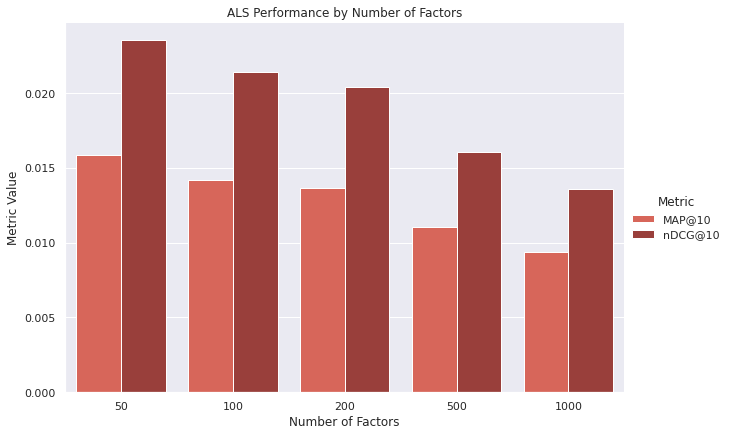

In [35]:
als_values = []
for r in performance_values['ALS']:
    als_values += [r[0], r[1]]
als_data = pd.DataFrame({'factors': [50, 50, 100, 100, 200, 200, 500, 500, 1000, 1000], 'Metric': 5 * ['MAP@10', 'nDCG@10'], 'values': als_values})
ax = sns.catplot(x='factors', y='values', data=als_data, hue='Metric', kind='bar', palette='Reds_d', height=6, aspect=1.5)
ax.set(title='ALS Performance by Number of Factors', xlabel='Number of Factors', ylabel='Metric Value')
plt.show()

También se puede visualizar el rendimiento de BPR según la misma variación:

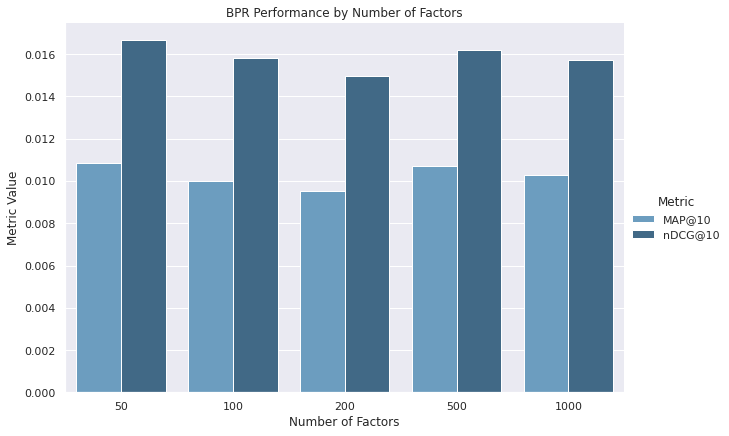

In [36]:
bpr_values = []
for r in performance_values['BPR']:
    bpr_values += [r[0], r[1]]
bpr_data = pd.DataFrame({'factors': [50, 50, 100, 100, 200, 200, 500, 500, 1000, 1000], 'Metric': 5 * ['MAP@10', 'nDCG@10'], 'values': bpr_values})
ax = sns.catplot(x='factors', y='values', data=bpr_data, hue='Metric', kind='bar', palette='Blues_d', height=6, aspect=1.5)
ax.set(title='BPR Performance by Number of Factors', xlabel='Number of Factors', ylabel='Metric Value')
plt.show()

# Actividad 4

Para obtener los embeddings debemos cargar el dataset de información de los animes:

In [37]:
reduced_info = df_info[['anime_id', 'content_embeddings']]
reduced_info

,anime_id,content_embeddings
0,1,"[-0.033500284, 0.03323533, 0.034192204, -0.049..."
1,5,"[-0.035846457, 0.022955496, 0.012560053, -0.03..."
2,6,"[0.051486682, -0.060088806, -0.029781044, -0.0..."
3,7,"[-0.0076218257, -0.026781121, 0.05598651, 0.00..."
4,15,"[-0.04619904, -0.053223185, -0.06296745, -0.03..."
...,...,...
2321,41389,"[-0.02934016, -0.015858095, -0.027120398, -0.0..."
2322,41433,"[-0.020284018, -0.009865774, -0.024244614, -0...."
2323,41468,"[0.0022373917, -0.019117152, 0.014048216, 0.01..."
2324,41619,"[-0.050313886, -0.017333463, 0.037420116, -0.0..."


Se recopilan los vectores de características de cada anime:

In [38]:
vectors = np.vstack(reduced_info['content_embeddings'].to_numpy())
vectors.shape

(2326, 512)

Las siguientes funciones permiten recomendar animes basándose en el perfil de los usuarios y los contenidos representados con los embeddings:

In [39]:
def content_rec(user_vector, anime_vectors, metric, top_n):
    distances = pairwise_distances(user_vector.reshape(1,-1), anime_vectors, metric=metric)
    recommended_ids = np.argpartition(distances[0], top_n)[:top_n]
    return sorted(recommended_ids, key=lambda x: distances[0][x])

def content_rec_test(test_data, user_vectors, anime_vectors, metric, top_n):
    users = user_items_val.keys()
    mean_map = 0.
    mean_ndcg = 0.
    valid_users = 0
    for user in users:
        user_animes = test_data[(test_data['user_id'] == user) & (test_data['rating'] == 1)]['anime_id'].to_list()
        if user_animes:
            valid_users += 1
            animes_not_watched = reduced_info[~reduced_info['anime_id'].isin(user_items[user])]
            vectors_not_watched = anime_vectors[animes_not_watched.index.to_list()]
            rec_ids = content_rec(user_vectors[user], vectors_not_watched, metric=metric, top_n=top_n)
            rec_animes = [animes_not_watched.iloc[idx]['anime_id'] for idx in rec_ids]
            rel_vector = [np.isin(rec_animes, user_animes, assume_unique=True).astype(int)]
            mean_map += mean_average_precision(rel_vector)
            mean_ndcg += ndcg_at_k(rel_vector[0], top_n)
    mean_map /= valid_users
    mean_ndcg /= valid_users
    return mean_map, mean_ndcg

Se realiza el análisis de sensibilidad, variando las métricas de similaridad (coseno, euclidiana, manhattan) y las dimensiones resultantes del Principal Component Analysis (PCA):

In [40]:
top_n = 10
dimensions = (10, 50, 100)
performance_values = {'cosine': {x: None for x in dimensions}, 'euclidean': {x: None for x in dimensions}, 'manhattan': {x: None for x in dimensions}}
for metric in ('cosine', 'euclidean', 'manhattan'):
    for dim in dimensions:
        pca_vectors = PCA(n_components=dim).fit_transform(vectors)
        default_user_vector = np.average(pca_vectors, axis=0)
        print(f'Metric: {metric}, Dimensions: {dim}')
        user_vectors = {}
        for user in user_items.keys():
            animes_watched = reduced_info[reduced_info['anime_id'].isin(user_items[user])]
            user_vector = default_user_vector
            if user_items[user]:
                user_vector = np.average(pca_vectors[animes_watched.index.to_list()], axis=0)
            user_vectors[user] = user_vector
        content_map, content_ndcg = content_rec_test(df_val, user_vectors, pca_vectors, metric=metric, top_n=top_n)
        performance_values[metric][dim] = (content_map, content_ndcg)

Metric: cosine, Dimensions: 10
Metric: cosine, Dimensions: 50
Metric: cosine, Dimensions: 100
Metric: euclidean, Dimensions: 10
Metric: euclidean, Dimensions: 50
Metric: euclidean, Dimensions: 100
Metric: manhattan, Dimensions: 10
Metric: manhattan, Dimensions: 50
Metric: manhattan, Dimensions: 100


Podemos ver los valores obtenidos:

In [41]:
print(performance_values)

{'cosine': {10: (0.005720341029560569, 0.00853052080238263), 50: (0.007789502027292993, 0.011281379394569364), 100: (0.007998736413273156, 0.011780794800843989)}, 'euclidean': {10: (0.0023895252101550583, 0.0040958331017915146), 50: (0.004383462650235821, 0.007310082209921803), 100: (0.00468915645775528, 0.007423251889404922)}, 'manhattan': {10: (0.002213902955573425, 0.00398506782263429), 50: (0.005307034066732839, 0.00795833647237055), 100: (0.004402434562749494, 0.007322723454618326)}}


A continuación se visualizan los resultados para la distancia coseno, variando las dimensiones de los vectores finales:

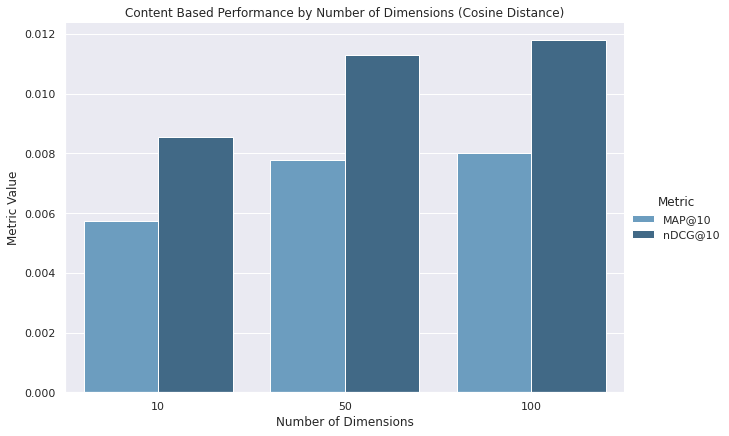

In [43]:
cosine_values = []
for r in performance_values['cosine'].values():
    cosine_values += [r[0], r[1]]
cosine_data = pd.DataFrame({'dimensions': [10, 10, 50, 50, 100, 100], 'Metric': 3 * ['MAP@10', 'nDCG@10'], 'values': cosine_values})
ax = sns.catplot(x='dimensions', y='values', data=cosine_data, hue='Metric', kind='bar', palette='Blues_d', height=6, aspect=1.5)
ax.set(title='Content Based Performance by Number of Dimensions (Cosine Distance)', xlabel='Number of Dimensions', ylabel='Metric Value')
plt.show()

Lo mismo para la distancia euclidiana:

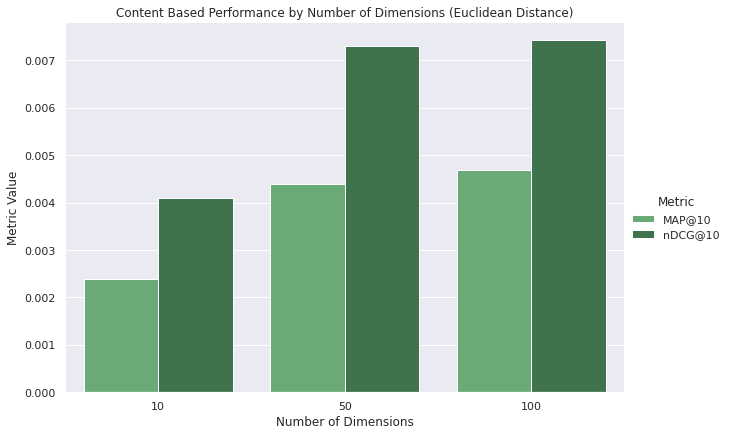

In [44]:
euclidean_values = []
for r in performance_values['euclidean'].values():
    euclidean_values += [r[0], r[1]]
euclidean_data = pd.DataFrame({'dimensions': [10, 10, 50, 50, 100, 100], 'Metric': 3 * ['MAP@10', 'nDCG@10'], 'values': euclidean_values})
ax = sns.catplot(x='dimensions', y='values', data=euclidean_data, hue='Metric', kind='bar', palette='Greens_d', height=6, aspect=1.5)
ax.set(title='Content Based Performance by Number of Dimensions (Euclidean Distance)', xlabel='Number of Dimensions', ylabel='Metric Value')
plt.show()

Finalmente, para la distancia manhattan:

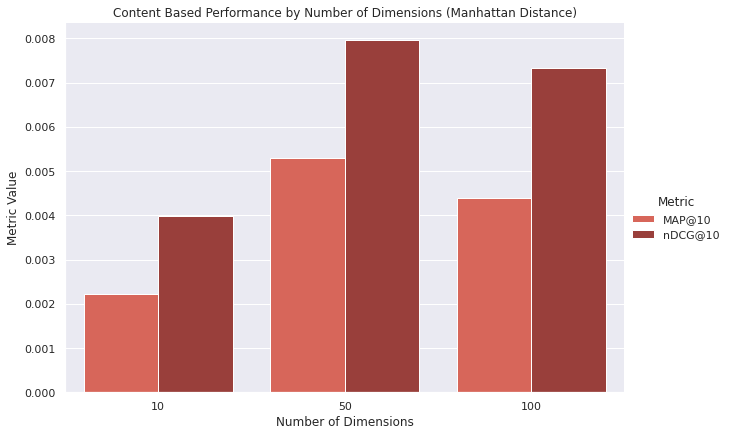

In [45]:
manhattan_values = []
for r in performance_values['manhattan'].values():
    manhattan_values += [r[0], r[1]]
manhattan_data = pd.DataFrame({'dimensions': [10, 10, 50, 50, 100, 100], 'Metric': 3 * ['MAP@10', 'nDCG@10'], 'values': manhattan_values})
ax = sns.catplot(x='dimensions', y='values', data=manhattan_data, hue='Metric', kind='bar', palette='Reds_d', height=6, aspect=1.5)
ax.set(title='Content Based Performance by Number of Dimensions (Manhattan Distance)', xlabel='Number of Dimensions', ylabel='Metric Value')
plt.show()

# Actividad 5

Realizamos una comparación de rendimiento entre los 5 modelos probados durante la tarea, considerando las métricas pedidas para 10, 20 y 30 recomendaciones:

In [46]:
most_popular_data = ['Most Popular']
random_data = ['Random']
als_data = ['ALS (50 Latent Factors)']
bpr_data = ['BPR (50 Latent Factors)']
content_based = ['Content Based (PCA@100 + Cosine Distance)']
als_model = implicit.als.AlternatingLeastSquares(factors=50, use_gpu=False)
als_model.fit(matrix)
bpr_model = implicit.bpr.BayesianPersonalizedRanking(factors=50, use_gpu=False)
bpr_model.fit(matrix)
pca_vectors = PCA(n_components=100).fit_transform(vectors)
default_user_vector = np.average(pca_vectors, axis=0)
user_vectors = {}
for user in user_items.keys():
    animes_watched = reduced_info[reduced_info['anime_id'].isin(user_items[user])]
    user_vector = default_user_vector
    if user_items[user]:
        user_vector = np.average(pca_vectors[animes_watched.index.to_list()], axis=0)
    user_vectors[user] = user_vector

# Eval
for n in (10, 20, 30):
    # Most Popular
    rec_list, most_popular_map, most_popular_ndcg = most_popular.testrec(input_file='datasets/val.csv',
                                                        dlmchar=b',',
                                                        header=True,
                                                        usercol=0,
                                                        itemcol=1,
                                                        ratingcol=2,
                                                        topn=n,
                                                        relevance_threshold=7,
                                                        includeRated=False)
    most_popular_data += [round(most_popular_ndcg, 6), round(most_popular_map, 6)]

    # Random
    random_map, random_ndcg = random_rec_test(df_train, df_val, n)
    random_data += [round(random_ndcg, 6), round(random_map, 6)]

    # Matrix Factorization (ALS)
    als_map, als_ndcg = evaluate_implicit(user_items_val, user_ids, user_item_matrix, als_model, n=n)
    als_data += [round(als_ndcg, 6), round(als_map, 6)]

    # Matrix Factorization (BPR)
    bpr_map, bpr_ndcg = evaluate_implicit(user_items_val, user_ids, user_item_matrix, bpr_model, n=n)
    bpr_data += [round(bpr_ndcg, 6), round(bpr_map, 6)]

    # Content Based
    content_map, content_ndcg = content_rec_test(df_val, user_vectors, pca_vectors, metric='cosine', top_n=n)
    content_based += [round(content_ndcg, 6), round(content_map, 6)]

100%|██████████| 100/100 [00:13<00:00,  7.52it/s, train_auc=86.60%, skipped=5.37%]


En la siguiente tabla se pueden ver los resultados:

In [47]:
final_performance = pd.DataFrame([most_popular_data, random_data, als_data, bpr_data, content_based],
    columns=['Model', 'nDCG@10', 'MAP@10', 'nDCG@20', 'MAP@20', 'nDCG@30', 'MAP@30'])
final_performance.style.hide_index()

Model,nDCG@10,MAP@10,nDCG@20,MAP@20,nDCG@30,MAP@30
Most Popular,0.012204,0.011027,0.017417,0.012846,0.021628,0.013672
Random,0.004309,0.002899,0.005570,0.002986,0.007844,0.003484
ALS (50 Latent Factors),0.022948,0.014717,0.033700,0.017475,0.042034,0.018983
BPR (50 Latent Factors),0.016732,0.011146,0.024909,0.013288,0.030534,0.014266
Content Based (PCA@100 + Cosine Distance),0.011925,0.008347,0.017771,0.009880,0.021820,0.010545


Concluímos que el mejor modelo corresponde a la Factorización Matricial Optimizada con ALS (ver el análisis en el informe). Procedemos a recomendar 10 animes para cada usuario del set de testing:

In [9]:
als_model = implicit.als.AlternatingLeastSquares(factors=50, use_gpu=False)
als_model.fit(matrix)
test_users = df_test['user_id'].value_counts().keys().to_list()
test_recommendations = {}
for user in test_users:
    final_rec_animes = [itemset[t[0]] for t in als_model.recommend(user_ids[user], user_item_matrix, 10)]
    test_recommendations[user] = final_rec_animes

100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


El diccionario ``test_recommendations`` contiene las recomendaciones pedidas, las que además guardamos en el archivo ``test_results.json``:

In [15]:
test_recommendations = {str(key): [int(x) for x in val] for key, val in test_recommendations.items()}
print({str(key): val for key, val in list(test_recommendations.items())[:10]})
with open('test_results.json', 'w') as file:
    json.dump(test_recommendations, file)

{'125862': [7054, 9919, 853, 2966, 14227, 5680, 11111, 6045, 4081, 2025], '325195': [2001, 28171, 28121, 30503, 32937, 10620, 121, 24833, 28223, 32282], '242274': [28171, 23847, 33486, 28907, 22297, 15451, 14813, 23755, 29803, 11741], '271978': [11597, 25777, 17074, 14741, 37510, 2251, 17265, 9756, 10165, 21855], '94190': [13601, 18153, 10620, 13759, 3588, 30, 11111, 31964, 17549, 226], '296522': [13601, 11597, 4282, 3783, 35760, 2167, 38524, 9919, 30503, 11843], '269793': [9756, 32182, 30831, 11061, 5081, 28851, 10863, 30015, 21881, 23283], '73946': [11597, 37779, 23847, 11111, 38524, 13759, 35790, 33352, 38408, 13601], '10489': [12189, 31240, 18897, 10080, 226, 10620, 3712, 30, 20, 11111], '230791': [30, 164, 2001, 431, 2236, 1, 121, 889, 5681, 47]}


# Actividad 6

Escogemos 3 usuarios del set de testing, y revisamos 10 animes previamente vistos, así como nuestras 10 recomendaciones según el modelo ganador (ALS):

In [16]:
for idx in (12, 14, 100):
    test_user_id = test_users[idx]
    print(f'User ID: {test_user_id}')
    print('Previously Watched')
    previous = df_info[df_info['anime_id'].isin(user_items[test_user_id][:10])].drop(['Synopsis', 'content', 'content_embeddings'], axis=1)
    display(previous.style.hide_index())
    print('Recommended')
    recommended = test_recommendations[str(test_user_id)]
    rec_data = []
    for rec in recommended:
        rec_row = df_info[df_info['anime_id'] == rec]
        rec_data.append((rec_row.iloc[0]['anime_id'], rec_row.iloc[0]['Name'], rec_row.iloc[0]['Genres']))
    df_result = pd.DataFrame(rec_data, columns=['anime_id', 'Name', 'Genres'])
    display(df_result.style.hide_index())

User ID: 302567
Previously Watched


anime_id,Name,Genres
268,Golden Boy,"Adventure, Comedy, Ecchi"
874,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen"
2251,Baccano!,"Action, Comedy, Historical, Mystery, Supernatural"
5081,Bakemonogatari,"Romance, Supernatural, Mystery, Vampire"
7785,Yojouhan Shinwa Taikei,"Mystery, Comedy, Psychological, Romance"
12893,Danshi Koukousei no Nichijou Specials,"Comedy, School, Shounen, Slice of Life"
28025,Tsukimonogatari,"Mystery, Comedy, Supernatural, Ecchi"
28701,Fate/stay night: Unlimited Blade Works 2nd Season,"Action, Fantasy, Magic, Supernatural"
31240,Re:Zero kara Hajimeru Isekai Seikatsu,"Psychological, Drama, Thriller, Fantasy"
31665,Hibike! Euphonium: Kakedasu Monaka,"Drama, Music, School"


Recommended


anime_id,Name,Genres
17074,Monogatari Series: Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"
15689,Nekomonogatari: Kuro,"Comedy, Supernatural, Romance, Ecchi"
6746,Durarara!!,"Action, Mystery, Supernatural"
21855,Hanamonogatari,"Mystery, Comedy, Supernatural"
18679,Kill la Kill,"Action, Comedy, Super Power, Ecchi, School"
31181,Owarimonogatari,"Mystery, Comedy, Supernatural, Vampire"
17265,Log Horizon,"Action, Game, Adventure, Magic, Fantasy"
11741,Fate/Zero 2nd Season,"Action, Supernatural, Magic, Fantasy"
28223,Death Parade,"Game, Mystery, Psychological, Drama, Thriller"
1519,Black Lagoon: The Second Barrage,"Action, Seinen"


User ID: 311453
Previously Watched


anime_id,Name,Genres
2476,School Days,"Harem, Drama, Romance, School"
2993,Rosario to Vampire,"Harem, Comedy, Romance, Ecchi, Vampire, Fantasy, School, Shounen"
10578,C³,"Action, Comedy, Ecchi, School, Supernatural"
13601,Psycho-Pass,"Action, Sci-Fi, Police, Psychological"
14713,Kamisama Hajimemashita,"Comedy, Demons, Supernatural, Romance, Fantasy, Shoujo"
15583,Date A Live,"Sci-Fi, Harem, Comedy, Romance, Mecha, School"
27655,Aldnoah.Zero 2nd Season,"Action, Mecha, Sci-Fi, Space"
27775,Plastic Memories,"Sci-Fi, Drama, Romance"
31680,Super Lovers,"Slice of Life, Comedy, Drama, Romance, Shounen Ai"
38671,Enen no Shouboutai,"Action, Supernatural, Shounen"


Recommended


anime_id,Name,Genres
18153,Kyoukai no Kanata,"Slice of Life, Supernatural, Fantasy"
9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural"
6746,Durarara!!,"Action, Mystery, Supernatural"
38000,Kimetsu no Yaiba,"Action, Demons, Historical, Shounen, Supernatural"
14467,K,"Action, Mystery, Super Power, Supernatural"
18679,Kill la Kill,"Action, Comedy, Super Power, Ecchi, School"
26243,Owari no Seraph,"Action, Military, Supernatural, Drama, Vampire, Shounen"
14513,Magi: The Labyrinth of Magic,"Action, Adventure, Fantasy, Magic, Shounen"
4898,Kuroshitsuji,"Action, Mystery, Comedy, Historical, Demons, Supernatural, Shounen"
25777,Shingeki no Kyojin Season 2,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"


User ID: 161872
Previously Watched


anime_id,Name,Genres
3588,Soul Eater,"Action, Fantasy, Comedy, Supernatural, Shounen"
6746,Durarara!!,"Action, Mystery, Supernatural"
10163,C: The Money of Soul and Possibility Control,"Action, Mystery, Super Power, Thriller"
14131,Girls & Panzer,"Action, Sports, Military, School"
16049,Toaru Kagaku no Railgun S,"Action, Sci-Fi, Super Power"
29786,Shimoneta to Iu Gainen ga Sonzai Shinai Taikutsu na Sekai,"Comedy, Ecchi, School"
31757,Kizumonogatari II: Nekketsu-hen,"Action, Mystery, Supernatural, Vampire"
32867,Bungou Stray Dogs 2nd Season,"Action, Mystery, Seinen, Super Power, Supernatural"
32937,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Parody, Supernatural, Magic, Fantasy"
36028,Golden Kamuy,"Action, Adventure, Historical, Seinen"


Recommended


anime_id,Name,Genres
32182,Mob Psycho 100,"Action, Slice of Life, Comedy, Supernatural"
199,Sen to Chihiro no Kamikakushi,"Adventure, Supernatural, Drama"
11597,Nisemonogatari,"Mystery, Comedy, Supernatural, Ecchi"
25777,Shingeki no Kyojin Season 2,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen"
18679,Kill la Kill,"Action, Comedy, Super Power, Ecchi, School"
2251,Baccano!,"Action, Comedy, Historical, Mystery, Supernatural"
38524,Shingeki no Kyojin Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
36456,Boku no Hero Academia 3rd Season,"Action, Comedy, Super Power, School, Shounen"
24833,Ansatsu Kyoushitsu,"Action, Comedy, School, Shounen"


(En el informe se analizan estos resultados y se sacan las conclusiones de este trabajo)